# ライブラリの読込

In [1]:
from modules.load import *
from modules.lstm import *
sns.set()

Using TensorFlow backend.


In [2]:
from tensorflow.keras.models import load_model

# データの読込

In [3]:
def make_data(concat):
    ex = concat.iloc[:,1:-1]
    ex = np.array(ex)
    ex=ex.reshape(-1,ex.shape[1],1)
    label = concat.iloc[:,-1]
    label = np.array(label)
    label = label.reshape(-1,1)
    label =one_hot(label)
    
    return ex,label

In [4]:
x = pd.read_csv("2s_time.csv").iloc[:,1:-1]
y = pd.read_csv("2s_time.csv").iloc[:,-1]

In [5]:
x = np.array(x).reshape(-1,20,1)
y = one_hot(np.array(y).reshape(-1,1))

In [6]:
print("xのshape:{}".format(x.shape))
print("yのshape:{}".format(y.shape))

xのshape:(5880, 20, 1)
yのshape:(5880, 6)


# トレーニングデータとテストデータに分割

In [108]:
X_train, X_test, Y_train, Y_test = split(x,y)

シャッフルする:1 シャッフルしない:21
testサイズを選んでください0.2


In [109]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

#  LSTMの実装

In [110]:
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional,LSTM,TimeDistributed
from keras_radam import RAdam

In [111]:
%env TF_KERAS = 1

env: TF_KERAS=1


In [153]:
#むやみに層を増やすと逆に学習しなくなる
BATCHSIZE = 32
UNITNUM   = 128
optimizer = RAdam()
model = Sequential()
model.add(LSTM(128, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True))
model.add(LSTM(128, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(6))
model.add(Activation("softmax"))
model.compile(RAdam(),loss = "categorical_crossentropy", metrics = ['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 20, 128)           66560     
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
_________________________________________________________________
activation_8 (Activation)    (None, 6)                 0         
Total params: 198,918
Trainable params: 198,918
Non-trainable params: 0
_________________________________________________________________


In [129]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')

In [130]:
history = model.fit(X_train, Y_train, batch_size=10, epochs=30,validation_split=0.2,callbacks=es)

Epoch 1/30
377/377 [==============================] - 7s 18ms/step - loss: 1.7675 - accuracy: 0.2014 - val_loss: 1.7156 - val_accuracy: 0.2455
Epoch 2/30
377/377 [==============================] - 7s 18ms/step - loss: 1.5778 - accuracy: 0.3130 - val_loss: 1.4273 - val_accuracy: 0.3858
Epoch 3/30
377/377 [==============================] - 7s 19ms/step - loss: 1.2612 - accuracy: 0.4627 - val_loss: 1.1765 - val_accuracy: 0.4857
Epoch 4/30
377/377 [==============================] - 7s 20ms/step - loss: 1.0587 - accuracy: 0.5615 - val_loss: 1.0543 - val_accuracy: 0.5345
Epoch 5/30
377/377 [==============================] - 6s 17ms/step - loss: 0.8759 - accuracy: 0.6386 - val_loss: 0.8147 - val_accuracy: 0.6546
Epoch 6/30
377/377 [==============================] - 7s 17ms/step - loss: 0.7302 - accuracy: 0.7101 - val_loss: 0.8542 - val_accuracy: 0.6397
Epoch 7/30
377/377 [==============================] - 7s 19ms/step - loss: 0.5987 - accuracy: 0.7584 - val_loss: 0.5367 - val_accuracy: 0.7991

# モデルの評価

In [131]:
def plot_history(history):
    # model loss graph

    def plot_history_loss(fit):
        axL.plot(fit.history['loss'], label="loss for training")
        axL.plot(fit.history['val_loss'],label="loss for validation")
        axL.set_title('model loss')
        axL.set_xlabel('epoch')
        axL.set_ylabel('loss')
        axL.legend(loc='upper right')

    # model accuracy graph

    def plot_history_accuracy(fit):
        axR.plot(fit.history['accuracy'],
                 label="accuracy for training")
        axR.plot(fit.history['val_accuracy'],label="accuracy for validation")
        axR.set_title('model accuracy')
        axR.set_xlabel('epoch')
        axR.set_ylabel('accuracy')
        axR.legend(loc='lower right')

    ig, (axL, axR) = plt.subplots(ncols=2, figsize=(10, 5))
    plt.subplots_adjust(wspace=0.5)
    plot_history_loss(history)
    plot_history_accuracy(history)

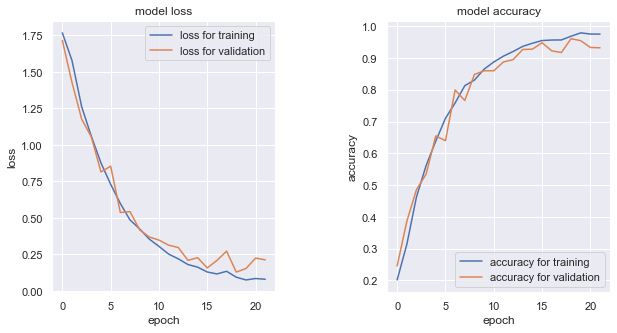

In [132]:
plot_history(history)

In [133]:
model.save( "model20_r.h5" )
model.save_weights("model_weight20_r.h5")

# テストデータ

In [134]:
evaluate_model(model,X_test,Y_test)

37/37 [==============================] - 0s 8ms/step - loss: 0.1362 - accuracy: 0.9617
loss: 0.13624340295791626 accuracy: 0.9617347121238708


# 評価の可視化

In [135]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [136]:
pred = model.predict(X_test)

In [137]:
#予測データ
y_pred = np.argmax(pred,axis=1)

In [138]:
#正解データ
Y_acc = np.argmax(Y_test,axis=1)

In [139]:
class_names = ["table","chaIr","denim","cardboard","pettobottle","finger"]

In [140]:
cf_matrix = confusion_matrix(Y_acc, y_pred)
cd_df = pd.DataFrame(cf_matrix)

In [141]:
cd_df.columns=class_names
cd_df.index=class_names

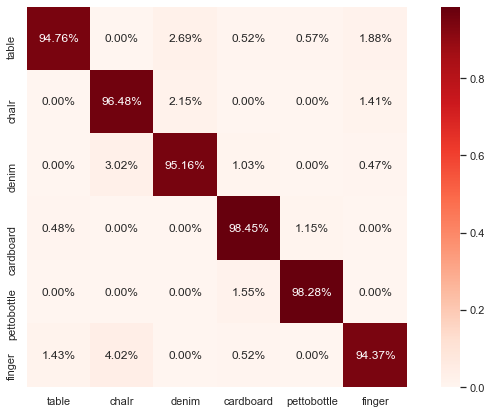

In [142]:
plt.figure(figsize = (12,7))
sns.heatmap(cd_df.astype('float') / cd_df.sum(axis=1), annot=True, fmt='.2%' ,square = True,cmap='Reds')
plt.show()

# 未知データ

In [154]:
#モデルの読込
model.load_weights('model_weight20_r.h5')#作成したモデルが学習した重みを読み込み

In [143]:
test_data = pd.read_csv("test.csv")

In [144]:
a,b = make_data(test_data)

In [160]:
X_train_kai, X_test_kai, Y_train_kai, Y_test_kai = split(a,b)

シャッフルする:1 シャッフルしない:21
testサイズを選んでください0.3


In [163]:
#二回目の学習で格段に精度が上がっていることが確認できる。
history2 = model.fit(X_train_kai, Y_train_kai, batch_size=10, epochs=1,validation_split=0.2,callbacks=es)

330/330 [==============================] - 6s 18ms/step - loss: 1.7542 - accuracy: 0.5942 - val_loss: 0.8299 - val_accuracy: 0.7318


In [164]:
evaluate_model(model,X_test_kai,Y_test_kai)

56/56 [==============================] - 0s 7ms/step - loss: 0.8269 - accuracy: 0.7443
loss: 0.8268930315971375 accuracy: 0.7443310618400574


In [165]:
y_pred_kai = model.predict(X_test_kai)
y_pred_kai = np.argmax(y_pred_kai,axis=1)
Y_acc_kai = np.argmax(Y_test_kai,axis=1)
cf_matrix_kai = confusion_matrix(Y_acc_kai, y_pred_kai)

In [166]:
cd_df_kai = pd.DataFrame(cf_matrix_kai)

In [167]:
cd_df_kai.columns=class_names
cd_df_kai.index=class_names

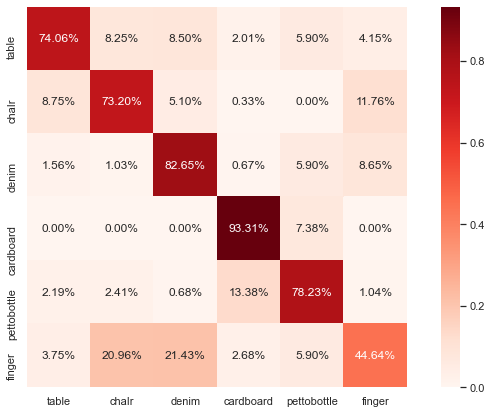

In [168]:
plt.figure(figsize = (12,7))
sns.heatmap(cd_df_kai.astype('float') / cd_df_kai.sum(axis=1), annot=True, fmt='.2%' ,square = True,cmap='Reds')
plt.show()